# Homework09

Exercises to practice dimensionality reduction with PCA

## Goals

- Add unsupervised pre-processing to our ML flow: encode -> normalize -> pre-process -> train -> evaluate
- Build an intuition for PCA and when/how to use it
- Understand the benefits of dimensionality reduction

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/Homework07/raw/main/Homework07_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [1]:
import PIL.Image as PImage

from os import listdir, path

from data_utils import PCA, RandomForestClassifier

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same one we used in `Homework07`. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [2]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [3]:
# TODO: check and see what is inside the list here
train_files[:10]

['17-85.jpg',
 '26-29.jpg',
 '07-11.jpg',
 '13-47.jpg',
 '23-73.jpg',
 '27-15.jpg',
 '11-94.jpg',
 '21-51.jpg',
 '02-48.jpg',
 '09-48.jpg']

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [10]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [5]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
label_data[:10]

[13, 21, 5, 11, 18, 22, 9, 16, 1, 7]

Like in `Homework07`, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

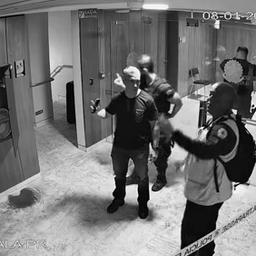

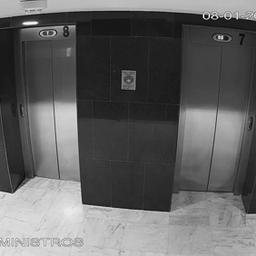

In [6]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did in Homewokr07 with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `Homework07`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [34]:
# TODO: run PCA, get DataFrame
pca = PCA(n_components=11)
cam_pca_df = pca.fit_transform(pixel_data)

# TODO: add "label" column
cam_pca_df["label"] = label_data

# TODO: print variance
print(pca.explained_variance())

# TODO: take a look at the first 5 rows
cam_pca_df.head(6)


0.8010406681172418


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,label
0,1211.783230,877.945502,-2586.613109,5250.305570,2018.252737,1691.884028,760.704558,1184.190915,444.397207,156.849131,-1298.311734,13
1,4362.018543,-249.771418,3036.742721,3715.018331,-845.729579,602.728265,-2545.029400,-3608.103959,-183.816087,140.435795,-1772.256985,21
2,-2187.666720,-8270.230054,9307.806825,-6118.796976,-3623.729350,-1108.254700,-2116.140291,3221.044394,-2980.706689,-4233.590698,28.251929,5
3,-4669.555572,-5856.007913,289.554542,5548.766814,-2111.406372,-2685.838451,4713.125989,4217.401252,-511.303458,2085.643571,-2117.455564,11
4,1670.591181,-6361.599954,-3268.298514,8846.542065,1572.842917,6545.546330,3806.843564,-1329.317406,-1578.318643,-2952.902587,4211.652559,18
5,13419.892968,-7018.929880,-5452.168547,-1013.252289,953.570576,306.085202,-976.851983,-1257.527330,-1209.292230,2341.555105,-292.777431,22


### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

<span style="color:lightgreen;">
- I keept 11 components because I was trying to do achive 80% variance to keep of information in the images. 
</span>

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

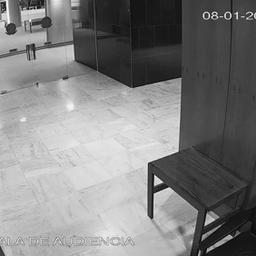

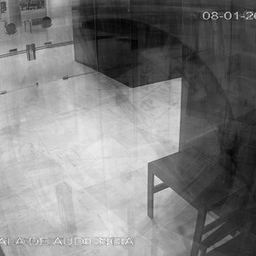

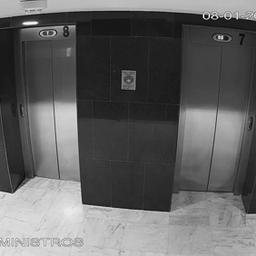

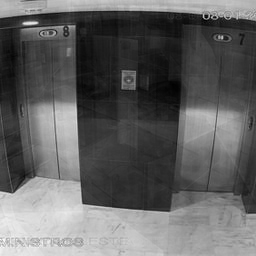

In [35]:
## Inverse transform df
pca_pixels = pca.inverse_transform(cam_pca_df)
# TODO: reconstruct image at index 0

display(make_image(pixel_data[15], width=256))
display(make_image(pca_pixels.loc[15], width=256))

# TODO: reconstruct image at index 10
display(make_image(pixel_data[10], width=256))
display(make_image(pca_pixels.loc[10], width=256))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [39]:
# TODO: create a classifier
model = RandomForestClassifier()

# TODO: split input and output features
features = cam_pca_df.drop(columns="label")
ids = cam_pca_df["label"]

# TODO: fit the model
model.fit(features, ids)

# TODO: run predictions
train_predictions = model.predict(features)



### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [40]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

<span style="color:lightgreen;">
I have a score of 1 which means a perfect fit, which is overfitting. This means that the model knows everything about the data. <br>
The model will most probably perform poorly on the test data beacause of it has overfitting on train data and not general enough on new data. 
</span>

### Run on Test set

Now we'll open the image files inside the `./data/image/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [41]:
# TODO: create a list of files in the test/ directory
TEST_PATH = "/workspaces/Homework09/data/image/0801-500/test"
test_files = [f for f in listdir(TEST_PATH) if f.endswith(".jpg")]

# TODO: check its length and content
len(test_files)

1573

We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [42]:
test_pixel_data = []

for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [ ]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one
test_pca_df = pca.transform(test_pixel_data)
test_pca_df.head()

In [50]:
test_pca_pixels = pca.inverse_transform(test_pca_df)

It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

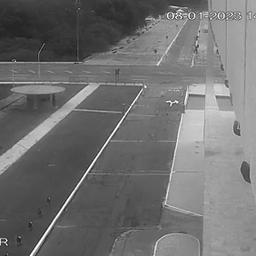

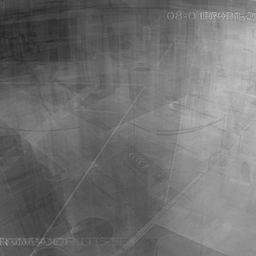

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,87.899296,93.060803,95.955604,92.573869,99.442977,109.442386,109.626848,107.411057,106.380593,107.633795,...,123.403614,121.519860,119.453552,119.868277,119.830952,119.280035,119.190574,117.793500,116.470963,116.770561
1,24.739910,19.911044,17.125516,15.344121,13.978717,12.032832,12.573100,13.227257,15.588966,19.146020,...,159.757724,158.558759,161.333207,162.993358,164.429063,164.667400,165.012737,166.164927,167.044977,163.630959
2,168.875097,168.251723,165.709749,166.747917,164.779066,159.537568,159.270514,160.484156,158.335335,156.182408,...,161.877257,164.871961,161.875308,163.338962,164.147224,164.994671,164.665858,164.180665,162.167958,160.866711
3,43.449193,44.524171,41.322415,43.793037,49.048079,50.281247,49.573811,45.984948,46.869148,49.331531,...,177.913423,177.917230,176.843021,176.911551,178.016782,178.763604,178.084657,176.766985,176.340446,175.399549
4,90.354005,88.455550,87.590480,89.017566,90.702846,91.967832,93.445095,94.292159,96.103738,97.899651,...,146.166732,144.437405,143.688819,142.886392,141.543919,139.731589,139.457064,140.061647,141.789216,138.020403
5,132.702847,137.267958,135.027397,146.245065,163.310727,171.502215,170.075697,165.393432,168.887247,172.344751,...,170.276348,169.358645,167.874421,166.667271,167.633506,170.143205,170.754692,165.625727,164.663200,168.153848


In [54]:
# TODO: reconstruct one or two images
display(make_image(test_pixel_data[30], width=256))
display(make_image(test_pca_pixels.loc[30], width=256))

# TODO: take a look at the first 5 rows
test_pca_pixels.head(6)

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

<span style="color:lightgreen;">

Because the model is traind on other data and the test data is new. The patterns and information from the train data are not exact in the test data. <br>
The photos are more blured and noisy because they have variations in pxiels that are not present in the train dataset and the model can not reconstruct them accuratly.
</span>



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [55]:
# TODO: run classifier. This is the same classifier already fitted on the train data above

test_features = test_pca_df
test_predicted = model.predict(test_features)

# TODO: get accuracy
CamUtils.classification_accuracy(test_files, test_predicted)

0.43038779402415767

### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to the classification model from <code>Homework07</code>? They can both be tuned to perform well, but how many features did we need last time in order to get an accuracy comparable to this?
</span>

<span style="color:lightgreen;">
The accuracy is .430 
The model is meaking a righ decision with a rate of 43% which in my opinion a good start as it's not guessing. <br>

To improve the model: 
- Adding more components to train the model on. 
- We can tune our RandomForest classifier. 
- Using another classification algorithm. 

In Homework 07 we did not use PCA to extract the most significant information from the dataset we had. <br>
The classification was trained on actual pixle values and not reduced significant data. <br>

Without PCA, we would need a lot more pixels simply because each pixel contains equal information about the image. <br>
Depending on the dataset, we might need to double the number of features. <br>
In contrast, with PCA, each component applies a linear strategy to capture the most important variation after the previous one. <br>
This means we can add components one by one without worrying about information loss. <br>

</span>